# Face Recognition Using CNN

## Tentang dataset

> Data tersebut berisi gambar wajah yang telah dipotong dari 17 orang yang dibagi ke dalam Pelatihan dan pengujian. Model akan dilatih menggunakan CNN menggunakan gambar-gambar di folder Pelatihan dan kemudian menguji model dengan menggunakan gambar-gambar yang tidak terlihat dari folder pengujian, untuk memeriksa apakah model tersebut dapat mengenali nomor wajah, yaitu label yang diberikan kepada setiap wajah selama pelatihan)

In [64]:
# import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import time
import os

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import Callback, EarlyStopping

In [12]:
train_dir = r"./Face Images/Final Training Images"
test_dir = r"./Face Images/Final Testing Images"

## Explorasi data

### Mengecek jumlah data

In [5]:
# Fungsi untuk menghitung jumlah gambar per kelas
def count_images_per_class(directory):
    data_info = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            num_images = len([f for f in os.listdir(label_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
            data_info.append((label, num_images))
    return data_info

   Pegawai  Jumlah Foto
0    face1           20
1   face10           17
2   face11           16
3   face12           15
4   face13           15
5   face14           16
6   face15           14
7   face16           14
8   face17           16
9    face2           16
10   face3           14
11   face4           15
12   face5           17
13   face6           15
14   face7           13
15   face8           12
16   face9           14


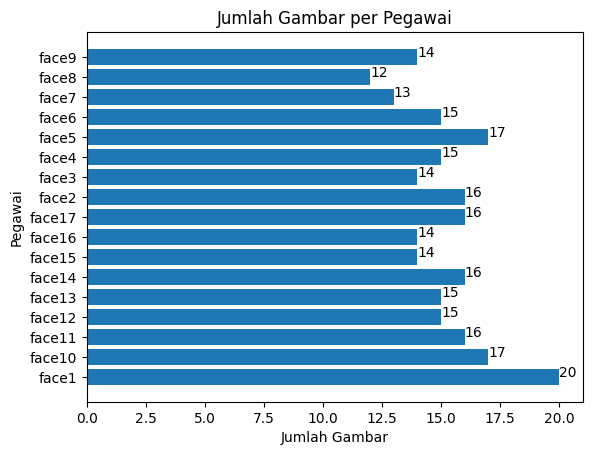

In [20]:
# Hitung jumlah gambar per kelas
data_info = count_images_per_class(train_dir)
df = pd.DataFrame(data_info, columns=['Pegawai', 'Jumlah Foto'])

# Tampilkan informasi jumlah gambar per kelas
print(df)

# Visualisasikan jumlah gambar per kelas
plt.barh(df['Pegawai'], df['Jumlah Foto'])
 
for index, value in enumerate(df['Jumlah Foto']):
    plt.text(value, index,str(value))
 
plt.xlabel('Jumlah Gambar')
plt.ylabel('Pegawai')
plt.title('Jumlah Gambar per Pegawai')
plt.show()

### Mengecek sample data tiap class

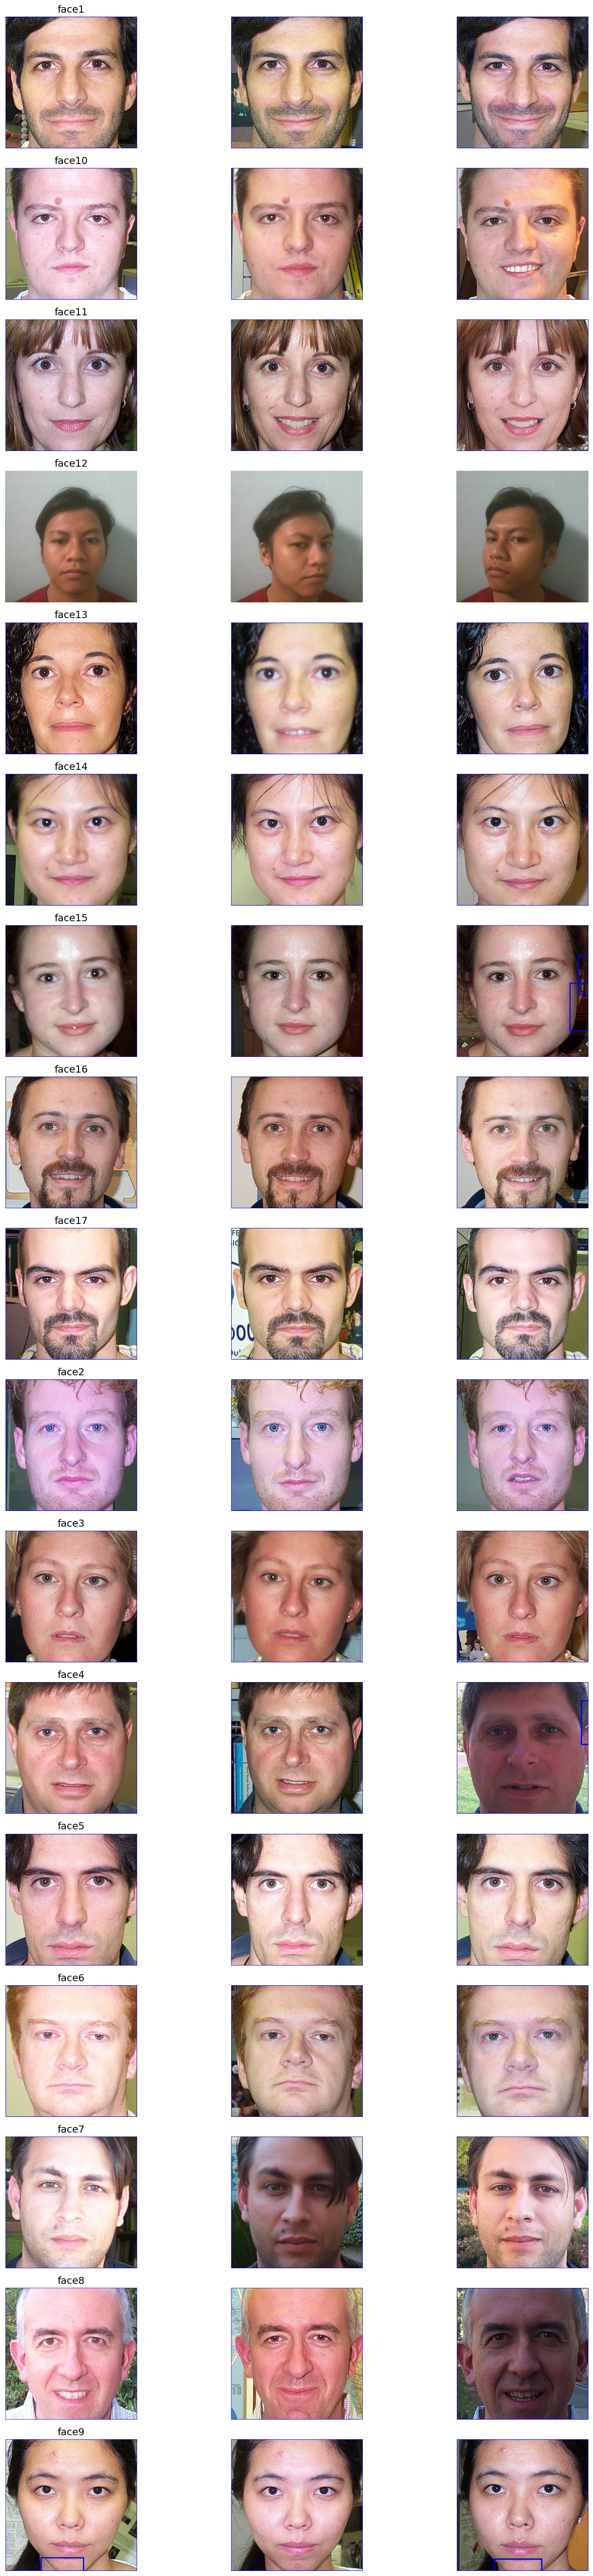

In [21]:
def show_images_from_folder(folder_path, num_images=3):
    """
    Menampilkan sejumlah gambar dari setiap subfolder di dalam folder_path.
    
    Parameters:
    - folder_path: Path ke folder utama yang berisi subfolder untuk setiap kelas.
    - num_images: Jumlah gambar yang akan ditampilkan dari setiap subfolder.
    """
    # Dapatkan daftar subfolder
    subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir()]
    
    # Tentukan jumlah baris dan kolom untuk subplot
    num_classes = len(subfolders)
    num_cols = num_images
    num_rows = num_classes

    # Buat figure untuk plot
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
    axes = axes.flatten() if num_classes > 1 else [axes]

    for idx, subfolder in enumerate(subfolders):
        # Dapatkan nama kelas (subfolder)
        class_name = os.path.basename(subfolder)
        
        # Dapatkan daftar gambar dalam subfolder
        image_files = [os.path.join(subfolder, f) for f in os.listdir(subfolder) if f.endswith(('.png', '.jpg', '.jpeg'))]

        for jdx, image_file in enumerate(image_files[:num_images]):
            # Baca gambar menggunakan OpenCV
            image = cv2.imread(image_file)
            # Konversi dari BGR (OpenCV default) ke RGB (matplotlib default)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Tentukan indeks untuk subplot
            ax_idx = idx * num_cols + jdx
            
            # Tampilkan gambar di subplot
            axes[ax_idx].imshow(image)
            axes[ax_idx].axis('off')
            if jdx == 0:
                axes[ax_idx].set_title(class_name, fontsize=14)

    plt.tight_layout()
    plt.show()
# Tampilkan beberapa gambar dari setiap kelas di folder train
show_images_from_folder(train_dir, num_images=3)

### Memeriksa ukuran gambar

In [22]:
# Fungsi untuk memeriksa ukuran gambar
def get_image_sizes(directory):
    image_sizes = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            for image_name in os.listdir(label_dir):
                if image_name.endswith(('.png', '.jpg', '.jpeg')):
                    image_path = os.path.join(label_dir, image_name)
                    image = cv2.imread(image_path)
                    if image is not None:
                        image_sizes.append(image.shape[:2])
    return image_sizes

In [23]:
# Periksa ukuran gambar
image_sizes = get_image_sizes(train_dir)
size_df = pd.DataFrame(image_sizes, columns=['Height', 'Width'])
size_df

Height  Width
0       304    304
1       321    321
2       335    335
3       331    331
4       329    329
..      ...    ...
254     311    311
255     307    307
256     316    316
257     296    296
258     308    308

[259 rows x 2 columns]

In [24]:
# Tampilkan informasi ukuran gambar
print(size_df.describe())

          Height      Width
count  259.00000  259.00000
mean   341.27027  341.27027
std     96.40232   96.40232
min    249.00000  249.00000
25%    305.00000  305.00000
50%    318.00000  318.00000
75%    334.50000  334.50000
max    720.00000  720.00000


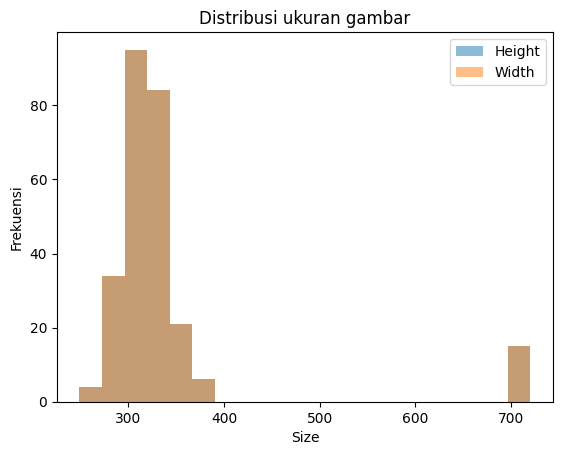

In [25]:
# Visualisasikan distribusi ukuran gambar
size_df.plot(kind='hist', alpha=0.5, bins=20)
plt.xlabel('Size')
plt.ylabel('Frekuensi')
plt.title('Distribusi ukuran gambar')
plt.show()

### Memeriksa distribusi pixel

In [26]:
# Fungsi untuk menghitung distribusi piksel
def calculate_pixel_distribution(image):
    chans = cv2.split(image)
    features = []
    for chan in chans:
        hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
        hist = hist / hist.sum()
        features.append(hist)
    return features

In [27]:
# Hitung distribusi piksel untuk semua gambar
pixel_distributions = []
for label in os.listdir(train_dir):
    label_dir = os.path.join(train_dir, label)
    if os.path.isdir(label_dir):
        for image_name in os.listdir(label_dir):
            if image_name.endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(label_dir, image_name)
                image = cv2.imread(image_path)
                if image is not None:
                    distribution = calculate_pixel_distribution(image)
                    pixel_distributions.append((label, *distribution))

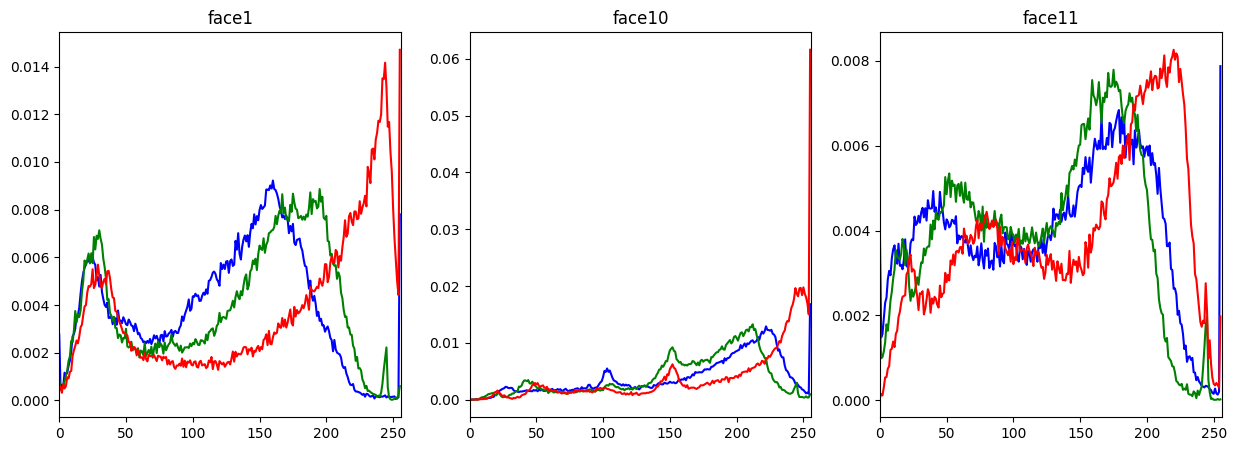

In [28]:
# Buat DataFrame untuk distribusi piksel
pixel_df = pd.DataFrame(pixel_distributions)

# Visualisasikan distribusi piksel untuk beberapa gambar (contoh)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, label in enumerate(df['Pegawai'].unique()[:3]): #Menggunakan 3 gambar saja
    example_image = os.path.join(train_dir, label, os.listdir(os.path.join(train_dir, label))[0])
    image = cv2.imread(example_image)
    chans = cv2.split(image)
    colors = ("b", "g", "r")
    for (chan, color) in zip(chans, colors):
        hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
        hist = hist / hist.sum()
        axes[i].plot(hist, color=color)
    axes[i].set_title(label)
    axes[i].set_xlim([0, 256])

plt.show()

## Membangun model

### Praproses data

In [46]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

In [133]:
# Data augmentation dan data generator
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 259 images belonging to 17 classes.
Found 67 images belonging to 17 classes.


In [134]:
# data pelatihan memiliki tag numerik untuk setiap wajah
Train_class = train_generator.class_indices

# memungkinkan untuk menyimpannya dalam kamus dengan pertukaran untuk referensi di masa mendatang
Result_class = {}
for value_tag, face_tag in zip(Train_class.values(),Train_class.keys()):
    Result_class[value_tag] = face_tag

In [135]:
# Mencetak label kelas untuk setiap wajah
test_generator.class_indices

{'face1': 0,
 'face10': 1,
 'face11': 2,
 'face12': 3,
 'face13': 4,
 'face14': 5,
 'face15': 6,
 'face16': 7,
 'face17': 8,
 'face2': 9,
 'face3': 10,
 'face4': 11,
 'face5': 12,
 'face6': 13,
 'face7': 14,
 'face8': 15,
 'face9': 16}

### Membangun & melatih model

In [79]:
from keras.applications import MobileNetV2
from keras.models import Model
from keras.layers import Flatten, Dense, Input
from keras.optimizers import Adam

In [138]:
from keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D

# Definisikan callback kustom untuk menghentikan pelatihan ketika akurasi > 96%
class CustomEarlyStopping(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') >= 0.96:
            print(f"\nAkurasi validasi mencapai {logs.get('val_accuracy') * 100:.2f}%, menghentikan pelatihan!")
            self.model.stop_training = True
            
# Load the MobileNetV2 model tanpa top layer
mobilenet_base = MobileNetV2(include_top=False, input_shape=(224, 224, 3), weights='imagenet')

# Freeze the base model
mobilenet_base.trainable = False

# Membangun model CNN
Model = Sequential([
    mobilenet_base,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.3),  # Dropout layer untuk mengurangi overfitting
    Dense(train_generator.num_classes, activation='softmax')
])

# Kompilasi model
Model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Menggunakan Early stopping untuk mengurangi waktu pelatihan
call = CustomEarlyStopping()

# Mengukur waktu yang dibutuhkan oleh model untuk melatih
StartTime = time.time()

# Melatih model
history = Model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    epochs=20,
    callbacks=[call])

Endtime = time.time()
print('Total Training Time taken: ', round((Endtime - StartTime) / 60), 'Minutes')


Epoch 1/20
8/8 [==============================] - 10s 984ms/step - loss: 2.7296 - accuracy: 0.2335 - val_loss: 1.5945 - val_accuracy: 0.4844
Epoch 2/20
8/8 [==============================] - 7s 924ms/step - loss: 1.2393 - accuracy: 0.6079 - val_loss: 0.7824 - val_accuracy: 0.7969
Epoch 3/20
8/8 [==============================] - 7s 855ms/step - loss: 0.5454 - accuracy: 0.8546 - val_loss: 0.3975 - val_accuracy: 0.9531
Epoch 4/20
8/8 [==============================] - 6s 818ms/step - loss: 0.3036 - accuracy: 0.9427 - val_loss: 0.3110 - val_accuracy: 0.9531
Epoch 5/20
8/8 [==============================] - 7s 843ms/step - loss: 0.1459 - accuracy: 0.9780 - val_loss: 0.2262 - val_accuracy: 0.9375
Epoch 6/20
8/8 [==============================] - ETA: 0s - loss: 0.1091 - accuracy: 0.9868
Akurasi validasi mencapai 96.88%, menghentikan pelatihan!
8/8 [==============================] - 7s 847ms/step - loss: 0.1091 - accuracy: 0.9868 - val_loss: 0.1527 - val_accuracy: 0.9688
Total Training Time 

In [140]:
# Simpan model
Model.save('Model_Face_Recognition_mobilenet.h5')

C:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Cek performa model

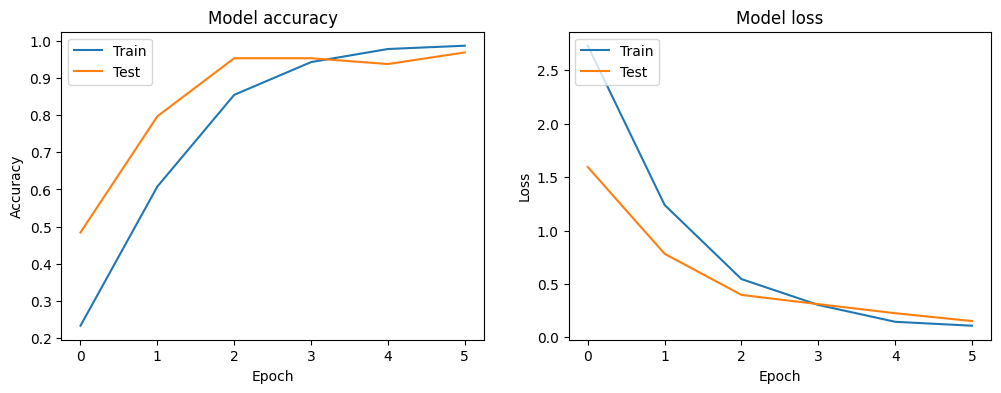

In [139]:
# Plot nilai akurasi training & testing 
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot nilai los  training & testing
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Tampilkan plots
plt.show()


Found 67 images belonging to 17 classes.
3/3 [==============================] - 3s 464ms/step


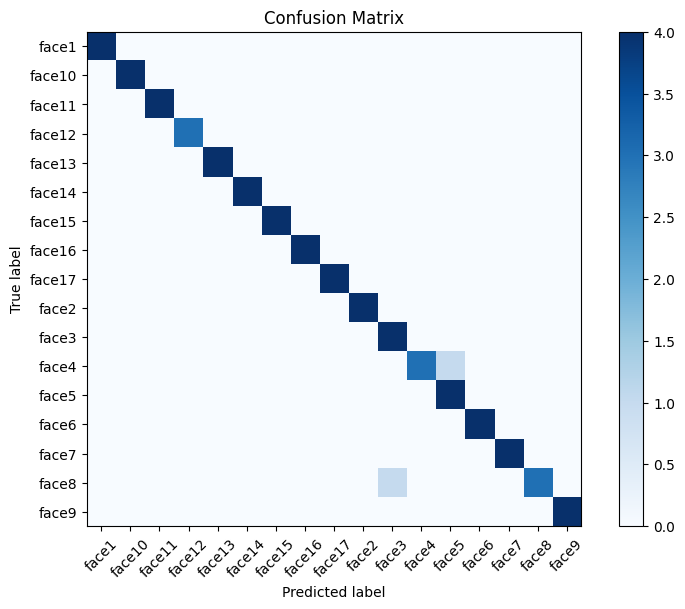

In [141]:
from sklearn.metrics import confusion_matrix
from keras.models import load_model

# Load model
model = load_model('Model_Face_Recognition_mobilenet.h5')

# Data generator untuk test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Penting: jangan acak urutan gambar
)

# Prediksi kelas untuk data test
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Label yang sebenarnya untuk data test
true_classes = test_generator.classes

# Nama kelas
class_labels = list(test_generator.class_indices.keys())

# Membuat confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [142]:
from sklearn.metrics import classification_report

# Membuat classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)

# Print classification report
print(report)

              precision    recall  f1-score   support

       face1       1.00      1.00      1.00         4
      face10       1.00      1.00      1.00         4
      face11       1.00      1.00      1.00         4
      face12       1.00      1.00      1.00         3
      face13       1.00      1.00      1.00         4
      face14       1.00      1.00      1.00         4
      face15       1.00      1.00      1.00         4
      face16       1.00      1.00      1.00         4
      face17       1.00      1.00      1.00         4
       face2       1.00      1.00      1.00         4
       face3       0.80      1.00      0.89         4
       face4       1.00      0.75      0.86         4
       face5       0.80      1.00      0.89         4
       face6       1.00      1.00      1.00         4
       face7       1.00      1.00      1.00         4
       face8       1.00      0.75      0.86         4
       face9       1.00      1.00      1.00         4

    accuracy              

### Menguji model menggunakan data test

In [143]:
from keras.preprocessing import image
import glob

# Panggil salah satu data
img_path=r".\Face Images\Final Testing Images\face1\1face10.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Lakukan penskalaan seperti yang dilakukan pada data training

# Prediksi kelas
prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction)
    
# Dapatkan label kelas yang sesuai dengan indeks kelas prediksi
class_labels = list(train_generator.class_indices.keys())
predicted_class_label = class_labels[predicted_class_index]
print(predicted_class_label)

1/1 [==============================] - 1s 827ms/step
face1


In [144]:
# Hasil prediksi menggunakan banyak data
## Load semua gambar dari folder data testing
main_ = r".\Face Images\Final Testing Images"
img_paths = glob.glob(os.path.join(main_,'**','*.jpg'))

print(img_paths[0:5]) # every image will be a PIL object
print('*'*50)

for path in img_paths:
    test_image = image.load_img(path,target_size=(150,150))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image,axis =0)
    result = model.predict(test_image,verbose=0)
    print(f'File: {os.path.basename(path)} - Prediction: ',Result_class[np.argmax(result)])

['.\\Face Images\\Final Testing Images\\face1\\1face10.jpg', '.\\Face Images\\Final Testing Images\\face1\\2face10.jpg', '.\\Face Images\\Final Testing Images\\face1\\3face10.jpg', '.\\Face Images\\Final Testing Images\\face1\\4face10.jpg', '.\\Face Images\\Final Testing Images\\face10\\1face4.jpg']
**************************************************


File: 1face10.jpg - Prediction:  face17
File: 2face10.jpg - Prediction:  face17
File: 3face10.jpg - Prediction:  face12
File: 4face10.jpg - Prediction:  face17
File: 1face4.jpg - Prediction:  face17
File: 2face4.jpg - Prediction:  face12
File: 3face4.jpg - Prediction:  face12
File: 4face4.jpg - Prediction:  face17
File: 1face5.jpg - Prediction:  face17
File: 2face5.jpg - Prediction:  face17
File: 3face5.jpg - Prediction:  face17
File: 4face5.jpg - Prediction:  face17
File: image_0021_Face_17.jpg - Prediction:  face3
File: image_0022_Face_17.jpg - Prediction:  face12
File: image_0023_Face_17.jpg - Prediction:  face3
File: 1face15.jpg - Prediction:  face17
File: 2face15.jpg - Prediction:  face8
File: 3face15.jpg - Prediction:  face17
File: 4face15.jpg - Prediction:  face3
File: 1face6.jpg - Prediction:  face17
File: 2face6.jpg - Prediction:  face17
File: 3face6.jpg - Prediction:  face3
File: 4face6.jpg - Prediction:  face3
File: 1face7.jpg - Prediction:  face3
File: 2face7.jpg - Predicti